In [1]:
import cv2 
import torch
import numpy as np 
import torch.nn as nn 
from torchvision import transforms
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 

from tqdm.auto import tqdm

/home/rjn/.conda/envs/main_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show(tensor,epoch ,channel = 1 , size = (28,28), num = 16 ):

    # tensor : 128 * 28 * 28
    data=tensor.detach().cpu().view(-1,channel,*size) #-> 128,1,28,28
    grid = make_grid(data[:num], nrow= 4).permute(1,2,0)# 1X28X28 -> 28x28x1
    plt.imshow(grid)
    # plt.show()
    plt.savefig(f"mnist_generated/{epoch}.png")


In [3]:
# hyperparameters and parameters: 
EPOCHS = 500
BATCH_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cuda:1"
current_step = 0
info_step = 500 #kun kun step ma visually show garene

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # dim of noise vector 
lr = 0.0001
loss_fn = nn.BCEWithLogitsLoss()



In [4]:
dataloader = DataLoader(MNIST('.',download=True, transform= transforms.ToTensor()), shuffle= True, batch_size=BATCH_SIZE)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 28709355.29it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 960540.58it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8517862.91it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2254500.45it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# The generator 
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64, 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256 x 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
            nn.Sigmoid(),
        )

    def forward(self, noise):
        return self.gen(noise)


def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(DEVICE)    


In [6]:
# The discriminator 

def disc_block(inp , opt):

    return nn.Sequential(
        nn.Linear(in_features=inp, out_features= opt),
        nn.LeakyReLU(0.2)
    )


class Discriminator(nn.Module):
    def __init__(self, i_dim = 784 , h_dim = 128) -> None:
        super().__init__()

        self.disc = nn.Sequential(
            disc_block(i_dim , h_dim * 4),
            disc_block(h_dim * 4 , h_dim * 2 ),
            disc_block(h_dim * 2 , h_dim),
            nn.Linear(h_dim  , 1)
        )
    
    def forward(self, noise):
        return self.disc(noise)

In [7]:

gen = Generator(z_dim).to(DEVICE)
gen_opt  = torch.optim.Adam(params= gen.parameters(), lr = lr)

disc = Discriminator().to(DEVICE)
disc_opt = torch.optim.Adam(params= disc.parameters(), lr = lr)

torch.Size([256, 1, 28, 28]) torch.Size([256])
tensor([0, 7, 1, 3, 6, 4, 7, 0, 4, 7])


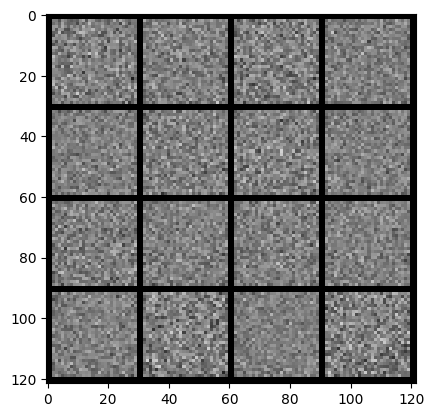

In [8]:
x,y = next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

nosie = gen_noise(BATCH_SIZE ,z_dim)
fake = gen(nosie)

show(fake,'noise')

In [9]:
# calclaute the loss 

def cal_gen_loss(loss_fn , gen , disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)

    targets = torch.ones_like(pred)
    generator_loss = loss_fn(pred,targets)

    return generator_loss

def cal_disc_loss(loss_fn, gen, disc, number, real, z_dim):

    noise = gen_noise(number , z_dim)
    fake = gen(noise)
    
    # we dont want change the parameters of generator when we are 
    # upadating the discriminator. so we detach.
    disc_fake = disc(fake.detach() )
    disc_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_fn(disc_fake, disc_fake_targets)

    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_fn(disc_real, disc_real_targets)

    disc_loss = (disc_fake_loss + disc_real_loss) / 2 

    return disc_loss




Epoch : 1 / 500


Training: 100%|██████████| 235/235 [00:08<00:00, 26.51it/s, disc_loss=3.22, gen_loss=0.266]


Epoch:0: / Gen loss: 0.26556593247867644 / disc_loss: 3.2215770269962065
Epoch : 2 / 500


Training: 100%|██████████| 235/235 [00:09<00:00, 25.66it/s, disc_loss=6.18, gen_loss=0.141] 


Epoch : 3 / 500


Training: 100%|██████████| 235/235 [00:08<00:00, 27.25it/s, disc_loss=4.8, gen_loss=0.0892] 


Epoch : 4 / 500


Training: 100%|██████████| 235/235 [00:08<00:00, 28.53it/s, disc_loss=3.84, gen_loss=0.108]


Epoch : 5 / 500


Training: 100%|██████████| 235/235 [00:08<00:00, 29.05it/s, disc_loss=5.86, gen_loss=0.0524]


Epoch : 6 / 500


Training: 100%|██████████| 235/235 [00:08<00:00, 28.89it/s, disc_loss=5.64, gen_loss=0.055] 


Epoch:5: / Gen loss: 0.05504033164854379 / disc_loss: 5.641262034152416
Epoch : 7 / 500


Training: 100%|██████████| 235/235 [00:08<00:00, 28.61it/s, disc_loss=5.51, gen_loss=0.0802]


Epoch : 8 / 500


Training: 100%|██████████| 235/235 [00:08<00:00, 28.19it/s, disc_loss=5.62, gen_loss=0.104]


Epoch : 9 / 500


Training:  14%|█▍        | 34/235 [00:01<00:07, 28.71it/s, disc_loss=5.76, gen_loss=0.129]


KeyboardInterrupt: 

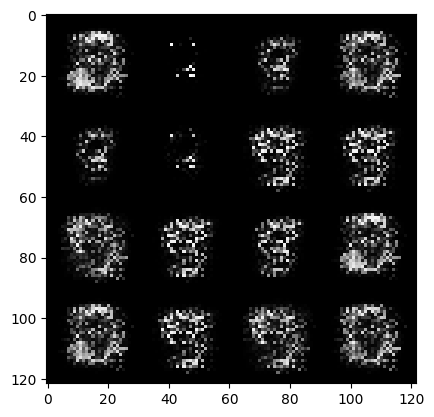

In [10]:
# Trainig loop: 
gen_loss_list = []
disc_loss_list = []
for epoch in range(EPOCHS):
    print(f"Epoch : {epoch + 1 } / {EPOCHS}")
    # print(f"{epoch+1}/{EPOCHS}")
    iterations = 0
    gen_iter_loss = 0.0
    disc_iter_loss = 0.0
    train_bar = tqdm(dataloader, desc=f"Training")
    for batch_idx, (real, _) in enumerate(train_bar):

        ### discriminator 
        disc_opt.zero_grad()

        current_batch_size = len(real) # BATCH_SIZE 128X1X28X28
        real = real.view(current_batch_size , -1 ) # BATCH_SIZE * 728
        real = real.to(DEVICE)
        disc_loss = cal_disc_loss(loss_fn, gen , disc, current_batch_size, real , z_dim)

        disc_loss.backward(retain_graph = True)
        disc_opt.step()

        ### generator 
        gen_opt.zero_grad()
        gen_loss = cal_gen_loss(loss_fn,gen, disc,current_batch_size, z_dim )
        gen_loss.backward(retain_graph = True)
        gen_opt.step()


        ### visualization
        gen_iter_loss += disc_loss.item()
        disc_iter_loss += gen_loss.item() 




        iterations+=1
        train_bar.set_postfix(
            gen_loss = gen_iter_loss/( batch_idx + 1), 
            disc_loss = disc_iter_loss / (batch_idx + 1 )
        )


    gen_loss_list.append(gen_iter_loss/iterations)
    disc_loss_list.append(disc_iter_loss/iterations)
    if epoch % 5 == 0:
        print(f"Epoch:{epoch}: / Gen loss: {gen_loss_list[-1]} / disc_loss: {disc_loss_list[-1]}")
        fake_noise = gen_noise(current_batch_size, z_dim)
        fake = gen(fake_noise)
        show(fake , epoch)



